In [1]:
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import utils_v2 as utils

Using TensorFlow backend.


## Google Stock - Predicting Today's trend

In [0]:
word_embeddings_matrix = utils.open_pickle(filename="generated_data/uci_words_embeddings")

In [3]:
word_embeddings_matrix.shape

(19774, 300)

In [0]:
news_sequences = utils.open_pickle(filename="generated_data/uci_news_sequences") 
news_sequences = np.array(list(news_sequences['news_sequence'].values))

In [5]:
news_sequences.shape

(82144, 15)

In [0]:
stock_labels = utils.open_pickle(filename="generated_data/GOOG_uci_stock_labels")

In [7]:
stock_labels.shape

(82144,)

In [0]:
indexes = [i for i in range(len(news_sequences))]
np.random.seed(1)
np.random.shuffle(indexes)
train_size = int(.75*len(indexes))

seq_train = np.array(list(news_sequences[indexes[:train_size]]))
y_train = np.array(stock_labels[indexes[:train_size]])

seq_test = np.array(list(news_sequences[indexes[train_size:]]))
y_test = np.array(stock_labels[indexes[train_size:]])

In [0]:
from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Conv1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model, load_model # Functional Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from keras.utils.np_utils import to_categorical

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
checkpoint = ModelCheckpoint('UciGoogChange1.h5', monitor='val_acc', mode='auto', verbose=1, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1)

# create the model
embedding_vecor_length = 32
model_today = Sequential()
model_today.add(Embedding(input_dim=word_embeddings_matrix.shape[0], output_dim=word_embeddings_matrix.shape[1],input_length=seq_train.shape[1]))
model_today.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_today.add(MaxPooling1D(pool_size=2))
model_today.add(LSTM(100))
model_today.add(Dense(3, activation='softmax'))
optimizer = Adam(lr=1e-3)
model_today.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_today.fit(seq_train, y_train, validation_split=0.05, epochs=25, batch_size=64, callbacks=[checkpoint, earlyStopping, reduceLR])

Train on 58527 samples, validate on 3081 samples
Epoch 1/25
58527/58527 [==============================] - 34s 574us/step - loss: 0.7123 - acc: 0.6757 - val_loss: 0.6174 - val_acc: 0.7209

Epoch 00001: val_acc improved from -inf to 0.72087, saving model to UciGoogChange1.h5
Epoch 2/25
58527/58527 [==============================] - 28s 480us/step - loss: 0.4607 - acc: 0.8078 - val_loss: 0.6181 - val_acc: 0.7322

Epoch 00002: val_acc improved from 0.72087 to 0.73223, saving model to UciGoogChange1.h5
Epoch 3/25
58527/58527 [==============================] - 28s 478us/step - loss: 0.3114 - acc: 0.8741 - val_loss: 0.7067 - val_acc: 0.7335

Epoch 00003: val_acc improved from 0.73223 to 0.73353, saving model to UciGoogChange1.h5
Epoch 4/25
58527/58527 [==============================] - 28s 476us/step - loss: 0.2126 - acc: 0.9154 - val_loss: 0.8294 - val_acc: 0.7215

Epoch 00004: val_acc did not improve from 0.73353

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974

In [13]:
model_today.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 300)           5932200   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 32)            28832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 6,014,535
Trainable params: 6,014,535
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_today = load_model('UciGoogChange1.h5')
scores = model_today.evaluate(seq_test, y_test, verbose=1)
scores

20536/20536 [==============================] - 6s 283us/step


[0.7009405981579503, 0.7266264121774852]

Accuracy: 0.923
Precision: 0.923
Recall: 0.923
F1 score: 0.923





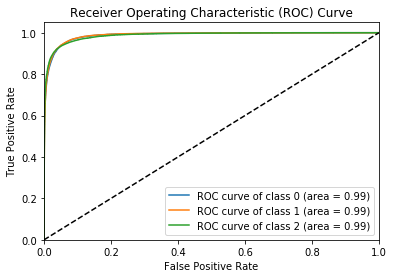

In [15]:
y_true = [np.argmax(y) for y in y_train]
y_pred = model_today.predict_classes(seq_train)
y_pred_prob = model_today.predict(seq_train)

utils.print_metrics(y_true, y_pred, y_pred_prob, 'uci_embedding_glove_news_only_train')

Accuracy: 0.727
Precision: 0.727
Recall: 0.727
F1 score: 0.727





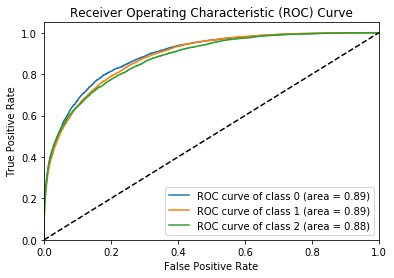

In [16]:
y_true = [np.argmax(y) for y in y_test]
y_pred = model_today.predict_classes(seq_test)
y_pred_prob = model_today.predict(seq_test)

utils.print_metrics(y_true, y_pred, y_pred_prob, 'uci_embedding_glove_news_only_test')